# Play with MOABB on the Thielen dataset

## Do the import

In [3]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import mne
from mne.decoding import CSP
from mne.decoding import Vectorizer
from pyriemann.estimation import Xdawn, XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC


import moabb

In [2]:
from moabb.datasets import Thielen2021
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import CVEP

moabb.set_log_level("info")
warnings.filterwarnings("ignore")


## Instantiating Dataset
 ---------------------

 The first thing to do is to instantiate the dataset that we want to analyze.
 MOABB has a list of many different datasets, each one containing all the
 necessary information for describing them, such as the number of subjects,
 size of trials, names of classes, etc.

 The dataset class has methods for:

 - downloading its files from some online source (e.g. Zenodo)
 - importing the data from the files in whatever extension they might be
   (like .mat, .gdf, etc.) and instantiate a Raw object from the MNE package

In [3]:
datasets = Thielen2021()
print(datasets.subject_list)
print(datasets.event_id)

#datasets.subject_list = [1, 2, 3]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
{'1.0': 101, '0.0': 100}


In [4]:
sessions = datasets.get_data(subjects=[1])

print(sessions)

subject = 1
session_name = "0"
run_name = "4"
raw = sessions[subject][session_name][run_name]


print(raw)


{1: {'0': {'0': <RawGDF | sub-01_20181128_block_1_main_eeg.gdf, 11 x 341479 (666.9 s), ~28.7 MB, data loaded>, '1': <RawGDF | sub-01_20181128_block_2_main_eeg.gdf, 11 x 341107 (666.2 s), ~28.6 MB, data loaded>, '2': <RawGDF | sub-01_20181128_block_3_main_eeg.gdf, 11 x 341105 (666.2 s), ~28.6 MB, data loaded>, '3': <RawGDF | sub-01_20181128_block_4_main_eeg.gdf, 11 x 341018 (666.0 s), ~28.6 MB, data loaded>, '4': <RawGDF | sub-01_20181128_block_5_main_eeg.gdf, 11 x 340901 (665.8 s), ~28.6 MB, data loaded>}}}
<RawGDF | sub-01_20181128_block_5_main_eeg.gdf, 11 x 340901 (665.8 s), ~28.6 MB, data loaded>


In [5]:
events = mne.find_events(raw)
print(events)

cond = np.logical_or(events[:,2]==100, events[:,2]==101)
print(cond)
# print(events[np.where(cond)])

epochs = mne.Epochs(raw, events[np.where(cond)], tmin=-0.3, tmax=0.7)
print(epochs)


[[  5477      0    200]
 [  5477      0    257]
 [  5477      0    101]
 ...
 [340540      0    100]
 [340548      0    101]
 [340558      0    257]]
[False False  True ...  True  True False]
<Epochs |  37800 events (good & bad), -0.300781 – 0.699219 s, baseline -0.300781 – 0 s, ~18 kB, data not loaded,
 '100': 18900
 '101': 18900>


In [7]:
# print(len(raw[1][0][0]))
# eeg = raw[8][0][0]
# plt.plot(np.linspace(0,len(eeg)*1/512,len(eeg)), eeg)
# plt.show()

# raw.plot()
epochs.plot(n_epochs=1, events=True)

## Choosing a Paradigm

In [38]:
paradigm=CVEP()
print(paradigm==None)

2023-11-10 12:41:28,242 WARNING MainThread moabb.paradigms.cvep Choosing the first None classes from all possible events.


False


In [39]:
#X, labels, meta = paradigm.get_data(dataset=datasets, subjects=datasets.subject_list)
print(datasets.event_id)

{'1.0': 101, '0.0': 100}


In [40]:

pipelines = {}
pipelines["RG+LDA"]=make_pipeline(
    XdawnCovariances(
        nfilter=2, estimator="lwf", xdawn_estimator="scm"
    ),
    TangentSpace(),
    LDA(solver="lsqr", shrinkage="auto"),
)

pipelines["Xdw+LDA"] = make_pipeline(
    Xdawn(nfilter=2, estimator="scm"), Vectorizer(), LDA(solver="lsqr", shrinkage="auto")
)
pipelines["RG+SVC"]=make_pipeline(
    XdawnCovariances(
        nfilter=2, estimator="lwf", xdawn_estimator="scm"
    ),
    TangentSpace(),
    LinearSVC(),
)


In [41]:
paradigm = CVEP(resample=128)
print("charging dataset")
print(datasets.event_id)
datasets.subject_list = datasets.subject_list[:2]
print(datasets.subject_list)
datasets = [datasets]
overwrite = True  # set to True if we want to overwrite cached results
evaluation = WithinSessionEvaluation(
    paradigm=paradigm, datasets=datasets, suffix="examples", overwrite=overwrite
)

results = evaluation.process(pipelines)

2023-11-10 12:41:32,969 WARNING MainThread moabb.paradigms.cvep Choosing the first None classes from all possible events.
2023-11-10 12:41:32,972 INFO MainThread moabb.evaluations.base Processing dataset: Thielen2021


charging dataset
{'1.0': 101, '0.0': 100}
[1, 2]


Thielen2021-WithinSession:   0%|          | 0/2 [00:00<?, ?it/s]

No hdf5_path provided, models will not be saved.


In [33]:
print(results)

      score        time   samples  carbon_emission subject session  channels  \
0  0.684788    2.255433  189000.0         0.013016       1       0         8   
1  0.587392    2.284070  189000.0         0.013100       2       0         8   
2  0.643889   93.592026  189000.0         0.504874       1       0         8   
3  0.574677   85.990631  189000.0         0.479318       2       0         8   
4  0.644460  135.943359  189000.0         0.790162       1       0         8   
5  0.574672  128.700821  189000.0         0.750867       2       0         8   

   n_sessions      dataset pipeline  
0           1  Thielen2021  Xdw+LDA  
1           1  Thielen2021  Xdw+LDA  
2           1  Thielen2021   RG+LDA  
3           1  Thielen2021   RG+LDA  
4           1  Thielen2021   RG+SVC  
5           1  Thielen2021   RG+SVC  


# PLot Result

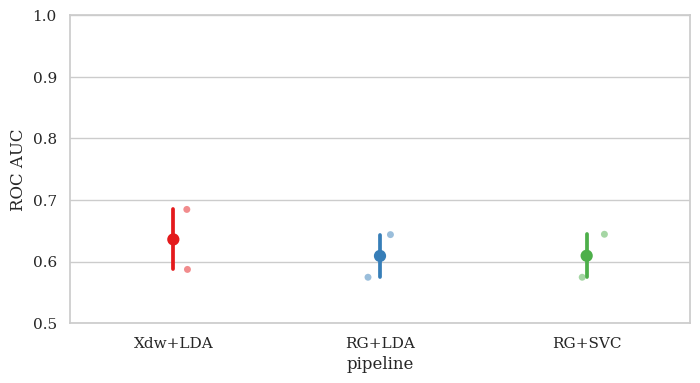

In [10]:
fig, ax = plt.subplots(facecolor="white", figsize=[8, 4])

sns.stripplot(
    data=results,
    y="score",
    x="pipeline",
    ax=ax,
    jitter=True,
    alpha=0.5,
    zorder=1,
    palette="Set1",
)
sns.pointplot(data=results, y="score", x="pipeline", ax=ax, palette="Set1")

ax.set_ylabel("ROC AUC")
ax.set_ylim(0.5, 1)

plt.show()